<a href="https://colab.research.google.com/github/pedroalexandertenezaca/lesiones-oculares-rd-ftm/blob/main/SegmentationU_NetBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_file_path = 'A. Segmentation.zip'
extract_dir = './'

# Crear el directorio de extracción si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Archivo '{zip_file_path}' descomprimido en '{extract_dir}'")

Archivo 'A. Segmentation.zip' descomprimido en './'


Paso 1: Definir las rutas y configuración

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm # Para barra de progreso (pip install tqdm)
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
INTERMEDIATE_SIZE = 1024
IMG_SIZE = 512 # Tamaño de entrada del U-Net
NUM_CLASSES = 6  # 1 Fondo + 5 Lesiones
BASE_DIR = "A. Segmentation"
SEED = 42

# Sufijos de archivo para cada lesión según IDRiD (ej: IDRiD_01_MA.tif)
LESION_SUFFIXES = {
    'MA': '_MA.tif',
    'HE': '_HE.tif',
    'EX': '_EX.tif',
    'SE': '_SE.tif',
    'OD': '_OD.tif'
}

Paso 2: Función para cargar y fusionar datos

In [ ]:
def load_idrid_data(img_dir, lesion_folders, img_size=(IMG_SIZE, IMG_SIZE)):
    X = []
    Y = []

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    print(f"Procesando {len(image_files)} imágenes desde: {img_dir.split('/')[-2]}")

    for img_name in tqdm(image_files):
        # 1. Cargar y preprocesar Imagen Original
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INTERMEDIATE_SIZE, INTERMEDIATE_SIZE))
        img = img / 255.0 # Normalizar
        X.append(img)

        file_id = os.path.splitext(img_name)[0]

        # 2. Construir la Máscara Multicanal
        lesion_masks = []
        lesion_keys = ['MA', 'HE', 'EX', 'SE', 'OD']

        for key in lesion_keys:
            mask_filename = file_id + LESION_SUFFIXES[key]
            mask_path = os.path.join(lesion_folders[key], mask_filename)

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (INTERMEDIATE_SIZE, INTERMEDIATE_SIZE), interpolation=cv2.INTER_NEAREST)
                # CORRECCIÓN: Convierte cualquier valor > 0 a 1 (arregla el problema del umbral 76)
                mask = (mask > 0).astype(np.uint8)
            else:
                # FIX: Create the zero mask with INTERMEDIATE_SIZE to match other masks
                mask = np.zeros((INTERMEDIATE_SIZE, INTERMEDIATE_SIZE), dtype=np.uint8)

            lesion_masks.append(mask)

        lesion_masks = np.array(lesion_masks)
        lesion_masks = np.moveaxis(lesion_masks, 0, -1)

        # 3. Calcular el canal de "Fondo" (Background)
        all_lesions = np.sum(lesion_masks, axis=-1)
        # 1 si no hay lesiones, 0 si sí hay
        background_mask = np.where(all_lesions == 0, 1, 0).astype(np.uint8)
        background_mask = np.expand_dims(background_mask, axis=-1)

        # 4. Concatenar: [Fondo, MA, HE, EX, SE, OD]
        final_mask = np.concatenate([background_mask, lesion_masks], axis=-1)
        Y.append(final_mask)

    return np.array(X), np.array(Y)

In [ ]:
# --- 1. CARGA DE DATOS ---

# Rutas de Entrenamiento
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/a. Training Set")
TRAIN_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/a. Training Set")
TRAIN_LESION_FOLDERS = {
    'MA': os.path.join(TRAIN_GT_DIR, "1. Microaneurysms"), 'HE': os.path.join(TRAIN_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TRAIN_GT_DIR, "3. Hard Exudates"), 'SE': os.path.join(TRAIN_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TRAIN_GT_DIR, "5. Optic Disc")
}

# Rutas de Testing (para validación)
TEST_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/b. Testing Set")
TEST_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/b. Testing Set")
TEST_LESION_FOLDERS = {
    'MA': os.path.join(TEST_GT_DIR, "1. Microaneurysms"), 'HE': os.path.join(TEST_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TEST_GT_DIR, "3. Hard Exudates"), 'SE': os.path.join(TEST_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TEST_GT_DIR, "5. Optic Disc")
}


X_train, y_train = load_idrid_data(TRAIN_IMG_DIR, TRAIN_LESION_FOLDERS)
X_test, y_test = load_idrid_data(TEST_IMG_DIR, TEST_LESION_FOLDERS)

print("\n--- RESUMEN DE DATOS CARGADOS ---")
print(f"Entrenamiento: X={X_train.shape}, Y={y_train.shape}")
print(f"Testing (Validación): X={X_test.shape}, Y={y_test.shape}")

Procesando 54 imágenes desde: 1. Original Images


100%|██████████| 54/54 [00:14<00:00,  3.69it/s]


Procesando 27 imágenes desde: 1. Original Images


100%|██████████| 27/27 [00:05<00:00,  5.12it/s]



--- RESUMEN DE DATOS CARGADOS ---
Entrenamiento: X=(54, 1024, 1024, 3), Y=(54, 1024, 1024, 6)
Testing (Validación): X=(27, 1024, 1024, 3), Y=(27, 1024, 1024, 6)


Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# --- 1. DEFINICIÓN DE FUNCIONES DE PÉRDIDA (LOSS) ---

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Métrica Dice (Asegura el casting a float32)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# Fondo sube de 0.1 a 0.5 para filtrar ruido.
# MA baja de 10.0 a 6.0 para mejorar la precisión.
CLASS_WEIGHTS = tf.constant([0.5, 6.0, 4.0, 2.0, 4.0, 1.0], dtype=tf.float32)


def stable_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # 1. Dice Loss (Métrica de solapamiento)
    dice = 1.0 - dice_coefficient(y_true, y_pred)

    # 2. Weighted Cross Entropy (Normalizada)
    # Multiplicamos por pesos ANTES del promedio para balancear clases
    weighted_cce = -tf.reduce_sum(y_true * K.log(y_pred) * CLASS_WEIGHTS, axis=-1)
    loss_cce = tf.reduce_mean(weighted_cce)

    # Combinación 50/50
    return 0.5 * dice + 0.5 * loss_cce



Modelo (Transfer Learning con VGG16)

1. Definición de la Arquitectura (VGG16-UNet)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def vgg16_unet_model(input_size=(512, 512, 3), num_classes=6):
    inputs = Input(input_size)

    # --- 1. ENCODER (VGG16 Pre-entrenado) ---
    # include_top=False: Eliminamos la parte que clasifica gatos/perros
    # weights='imagenet': Cargamos la "sabiduría" previa
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Extraemos las capas clave para las Skip Connections
    # VGG16 reduce la imagen a la mitad en cada bloque
    s1 = base_model.get_layer("block1_conv2").output  # 256x256, 64 filtros
    s2 = base_model.get_layer("block2_conv2").output  # 128x128, 128 filtros
    s3 = base_model.get_layer("block3_conv3").output  # 64x64, 256 filtros
    s4 = base_model.get_layer("block4_conv3").output  # 32x32, 512 filtros

    # Bottleneck (Punto más profundo)
    b1 = base_model.get_layer("block5_conv3").output  # 16x16, 512 filtros

    # Opcional: Descongelar todo para fine-tuning completo desde el inicio
    base_model.trainable = True

    # --- 2. DECODER (Aprende a segmentar) ---
    def decoder_block(input_tensor, skip_tensor, filters):
        x = UpSampling2D((2, 2))(input_tensor)
        x = Concatenate()([x, skip_tensor])
        x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Reconstruimos la imagen subiendo niveles
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # --- 3. SALIDA ---
    outputs = Conv2D(num_classes, 1, activation="softmax")(d4)

    model = Model(inputs=inputs, outputs=outputs, name="VGG16_UNet")
    return model

GENERADOR CON AUMENTO DE DATOS

In [ ]:


import tensorflow as tf
import random

# --- 1. GENERADOR CON AUMENTO DE DATOS ---
# Agregamos rotaciones, espejos y cambios de brillo sobre la marcha

def augmented_patch_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.6):
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]
    max_y = H - patch_size
    max_x = W - patch_size

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Selección de imagen y coordenadas (Igual que antes)
            idx = np.random.randint(0, N)
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                coords = lesion_coords[idx]
                target_y, target_x = coords[np.random.randint(len(coords))]
                y_start = target_y - np.random.randint(patch_size // 4, patch_size * 3 // 4)
                x_start = target_x - np.random.randint(patch_size // 4, patch_size * 3 // 4)
            else:
                y_start = np.random.randint(0, max_y)
                x_start = np.random.randint(0, max_x)

            y_start = np.clip(y_start, 0, max_y)
            x_start = np.clip(x_start, 0, max_x)

            # Extraer parche base
            img_patch = X_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]
            mask_patch = Y_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]

            # --- AUMENTO DE DATOS ALEATORIO ---
            # 1. Flip Horizontal
            if random.random() > 0.5:
                img_patch = np.fliplr(img_patch)
                mask_patch = np.fliplr(mask_patch)

            # 2. Flip Vertical
            if random.random() > 0.5:
                img_patch = np.flipud(img_patch)
                mask_patch = np.flipud(mask_patch)

            # 3. Rotación (0, 90, 180, 270)
            k = random.randint(0, 3)
            if k > 0:
                img_patch = np.rot90(img_patch, k)
                mask_patch = np.rot90(mask_patch, k)

            # 4. Brillo / Contraste (Solo a la imagen, no a la máscara)
            # Hacemos esto con funciones de TF o numpy simple
            if random.random() > 0.5:
                # Factor aleatorio entre 0.8 y 1.2
                factor = 0.8 + random.random() * 0.4
                img_patch = img_patch * factor
                img_patch = np.clip(img_patch, 0, 1)

            batch_x[i] = img_patch
            batch_y[i] = mask_patch

        yield (batch_x, batch_y)

Datos en Alta Resolución

In [ ]:
print(f"Entrenamiento: X={X_train.shape}, Y={y_train.shape}")
print(f"Testing (Validación): X={X_test.shape}, Y={y_test.shape}")

Entrenamiento: X=(54, 1024, 1024, 3), Y=(54, 1024, 1024, 6)
Testing (Validación): X=(27, 1024, 1024, 3), Y=(27, 1024, 1024, 6)


PASO 1: Mapeo de Coordenadas y Generador

In [ ]:
import numpy as np
from tqdm import tqdm

# --- 1. MAPEO DE COORDENADAS ---
def get_lesion_coordinates(Y_data):
    """
    Genera un diccionario donde key=idx_imagen y value=lista de coordenadas (y,x)
    de píxeles que contienen CUALQUIER lesión (canales 1 a 5).
    """
    lesion_coords = {}
    N = Y_data.shape[0]

    print("Escaneando imágenes para encontrar lesiones...")
    for idx in tqdm(range(N)):
        # Sumamos canales 1-5 (MA, HE, EX, SE, OD). Ignoramos Fondo (0).
        # Nota: Y_data debe ser (N, H, W, 6)
        mask_lesions = np.sum(Y_data[idx, :, :, 1:], axis=-1)

        # Obtener coordenadas donde hay algo (valor > 0)
        ys, xs = np.where(mask_lesions > 0)

        # Si la imagen tiene lesiones, guardamos las coordenadas
        if len(ys) > 0:
            # Guardamos como lista de pares (y, x)
            coords = np.column_stack((ys, xs))
            lesion_coords[idx] = coords

    print(f"✅ Se encontraron lesiones en {len(lesion_coords)} de {N} imágenes.")
    return lesion_coords

# --- 2. GENERADOR ENFOCADO (HARD NEGATIVE MINING) ---
def lesion_aware_patch_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.7):
    """
    Genera parches.
    - 70% del tiempo: Centra el parche en una lesión real.
    - 30% del tiempo: Parche aleatorio (para aprender fondo).
    """
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]

    # Pre-calcular límites para no salirnos de la imagen
    max_y = H - patch_size
    max_x = W - patch_size

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Elegir imagen aleatoria
            idx = np.random.randint(0, N)

            # Decidir estrategia: ¿Enfocado o Aleatorio?
            # Solo podemos enfocar si la imagen 'idx' tiene lesiones registradas
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                # --- ESTRATEGIA ENFOCADA ---
                # 1. Obtener todas las coordenadas de lesión de esta imagen
                coords = lesion_coords[idx]

                # 2. Elegir un punto de lesión al azar
                target_y, target_x = coords[np.random.randint(len(coords))]

                # 3. Calcular esquina superior izquierda para que 'target' quede en el centro aprox
                # Aleatorizamos un poco el centro para que no sea siempre el píxel exacto del medio
                y_start = target_y - np.random.randint(patch_size // 4, patch_size * 3 // 4)
                x_start = target_x - np.random.randint(patch_size // 4, patch_size * 3 // 4)

            else:
                # --- ESTRATEGIA ALEATORIA (FONDO) ---
                y_start = np.random.randint(0, max_y)
                x_start = np.random.randint(0, max_x)

            # --- CLIPPING (Seguridad) ---
            # Asegurar que las coordenadas estén dentro de la imagen válida
            y_start = np.clip(y_start, 0, max_y)
            x_start = np.clip(x_start, 0, max_x)

            # --- EXTRACCIÓN ---
            batch_x[i] = X_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]
            batch_y[i] = Y_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]

        yield (batch_x, batch_y)

PASO 2: Ejecución de Mapeo e Instanciación

In [ ]:
# 1. Generar mapas de coordenadas (Tarda unos segundos)
print("--- Mapeando Entrenamiento ---")
coords_train = get_lesion_coordinates(y_train)

print("--- Mapeando Testing ---")
coords_test = get_lesion_coordinates(y_test)

# 2. Crear los generadores
# --- NUEVA CONFIGURACIÓN DE ALTA RESOLUCIÓN ---
NEW_IMG_SIZE = 512   # Antes era 256
NEW_BATCH_SIZE = 4   # Bajamos de 8/16 a 4 para que entre en la T4

train_gen_highres = augmented_patch_generator(
    X_train, y_train, coords_train,
    batch_size=NEW_BATCH_SIZE,
    patch_size=NEW_IMG_SIZE,
    focus_ratio=0.6
)

val_gen_focused = lesion_aware_patch_generator(
    X_test, y_test, coords_test, NEW_BATCH_SIZE, NEW_IMG_SIZE, focus_ratio=0.50 # 50% en validación para balancear
)

--- Mapeando Entrenamiento ---
Escaneando imágenes para encontrar lesiones...


100%|██████████| 54/54 [00:01<00:00, 32.62it/s]


✅ Se encontraron lesiones en 54 de 54 imágenes.
--- Mapeando Testing ---
Escaneando imágenes para encontrar lesiones...


100%|██████████| 27/27 [00:00<00:00, 32.96it/s]

✅ Se encontraron lesiones en 27 de 27 imágenes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

K.clear_session()

# 1. Instanciar VGG16 con entrada 512x512
# Nota: VGG16 acepta cualquier tamaño, pero definimos el Input explícito
print(f"Creando Modelo High-Res ({NEW_IMG_SIZE}x{NEW_IMG_SIZE})...")
model= vgg16_unet_model(input_size=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3), num_classes=6)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=stable_weighted_loss,
    metrics=['accuracy', dice_coefficient]
)

# 2. Callbacks
callbacks = [
    ModelCheckpoint('vgg16_512_final.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# 3. Entrenar
print("Iniciando entrenamiento...")
history = model.fit(
    train_gen_highres,
    validation_data=val_gen_focused,
    steps_per_epoch=200, # Bajamos los pasos porque el batch es menor y tarda más
    validation_steps=50,
    epochs=50,
    callbacks=callbacks
)

Creando Modelo High-Res (512x512)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
⏳ Iniciando entrenamiento...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.7011 - dice_coefficient: 0.3991 - loss: 0.6940
Epoch 1: val_loss improved from inf to 3.96031, saving model to vgg16_512_final.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.7019 - dice_coefficient: 0.3998 - loss: 0.6932 - val_accuracy: 0.0851 - val_dice_coefficient: 0.0631 - val_loss: 3.9603 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9439 - dice_coefficient: 0.7177 - loss: 0.3342
Epoch 2: val_loss improved from 3.96031 to 0.38070, saving model to vgg16_512_final.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9439 - dice_coefficient: 0.7178 - loss: 0.3340 - val_accuracy: 0.8442 - val_dice_coefficient: 0.6477 - val_loss: 0.3807 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9

# Testing

Paso 1: Cargar el Mejor Modelo y Preparar Datos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. CARGAR EL MEJOR MODELO
# Usa el nombre del archivo que definiste en tu último entrenamiento
checkpoint_path = '/content/vgg16_512_final.keras' # O 'unet_thesis_tversky.keras'

try:
    model.load_weights(checkpoint_path)
    print(f"Pesos cargados exitosamente desde: {checkpoint_path}")
except:
    print("No se encontró el checkpoint. Usando los pesos actuales de la memoria.")

# PREPARAR EL GENERADOR DE TEST (Evaluación Completa)
# Usamos focus_ratio=0.5 para que la evaluación sea balanceada entre zonas sanas y enfermas
new_test_gen_full = lesion_aware_patch_generator(
    X_test, y_test, coords_test,
    batch_size=4, patch_size=NEW_IMG_SIZE, focus_ratio=0.5
)

# Calculamos cuántos pasos se necesitan para recorrer todo el dataset de prueba varias veces
# Esto asegura resultados estadísticamente sólidos
STEPS_EVAL = (len(X_test) * 20) // 4
print("STEPS_EVAL: " + str(STEPS_EVAL))

No se encontró el checkpoint. Usando los pesos actuales de la memoria.
STEPS_EVAL: 135


Paso 2: Generador de Reporte Clínico (Métricas)

In [ ]:
def generate_clinical_report(model, generator, steps):
    print(f"🏥 Generando Reporte Clínico (Evaluando {steps} lotes)...")

    # Acumuladores para TP, FP, FN por clase
    # Shape: (6 clases)
    total_tp = np.zeros(6)
    total_fp = np.zeros(6)
    total_fn = np.zeros(6)

    class_names = ['Fondo', 'Microaneurismas (MA)', 'Hemorragias (HE)',
                   'Exudados Duros (EX)', 'Exudados Blandos (SE)', 'Disco Óptico (OD)']

    for _ in tqdm(range(steps)):
        X_batch, y_true_batch = next(generator)

        # Predicción
        y_pred_prob = model.predict(X_batch, verbose=0)
        y_pred_classes = np.argmax(y_pred_prob, axis=-1)
        y_true_classes = np.argmax(y_true_batch, axis=-1)

        # Calcular métricas por lote para cada clase
        for i in range(6):
            true_mask = (y_true_classes == i)
            pred_mask = (y_pred_classes == i)

            # True Positives: Estaba en REAL y el modelo dijo PRED
            tp = np.sum(true_mask & pred_mask)
            # False Positives: No estaba en REAL pero el modelo dijo PRED (Falsa Alarma)
            fp = np.sum((~true_mask) & pred_mask)
            # False Negatives: Estaba en REAL pero el modelo lo ignoró (Paciente perdido)
            fn = np.sum(true_mask & (~pred_mask))

            total_tp[i] += tp
            total_fp[i] += fp
            total_fn[i] += fn

    # --- CÁLCULO FINAL DE MÉTRICAS ---
    results = []
    for i in range(6):
        tp = total_tp[i]
        fp = total_fp[i]
        fn = total_fn[i]

        # Dice Score: 2TP / (2TP + FP + FN)
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)

        # Sensibilidad (Recall): TP / (TP + FN) -> ¿Cuántas lesiones reales encontré?
        sensitivity = tp / (tp + fn + 1e-6)

        # Precisión (Precision): TP / (TP + FP) -> ¿De lo que encontré, cuánto era real?
        precision = tp / (tp + fp + 1e-6)

        results.append({
            "Clase": class_names[i],
            "Dice Score": round(dice, 4),
            "Sensibilidad (Recall)": round(sensitivity, 4),
            "Precisión": round(precision, 4)
        })

    # Crear DataFrame bonito
    df_results = pd.DataFrame(results)
    return df_results

Reporte Clínico

In [ ]:
# --- EVALUAR MODELO ---
df_metrics = generate_clinical_report(model, new_test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO ---")
display(df_metrics)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [01:04<00:00,  2.08it/s]


--- RESULTADOS FINALES: MODELO ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9868                 0.9815     0.9921
1   Microaneurismas (MA)      0.4070                 0.5800     0.3134
2       Hemorragias (HE)      0.6408                 0.7366     0.5670
3    Exudados Duros (EX)      0.8028                 0.8695     0.7455
4  Exudados Blandos (SE)      0.6038                 0.7005     0.5306
5      Disco Óptico (OD)      0.9653                 0.9771     0.9538

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Usamos los nombres de métricas correctos de la compilación
    acc = history.history['dice_coefficient']
    val_acc = history.history['val_dice_coefficient']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Gráfica de Dice (Precisión de Segmentación)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Dice')
    plt.plot(epochs, val_acc, 'r', label='Validation Dice')
    plt.title('Dice Coefficient (Métrica de Segmentación)')
    plt.legend()

    # Gráfica de Loss (Pérdida Ponderada)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Weighted Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Weighted Loss')
    plt.title('Weighted Combined Loss (Pérdida Ponderada)')
    plt.legend()

    plt.show()

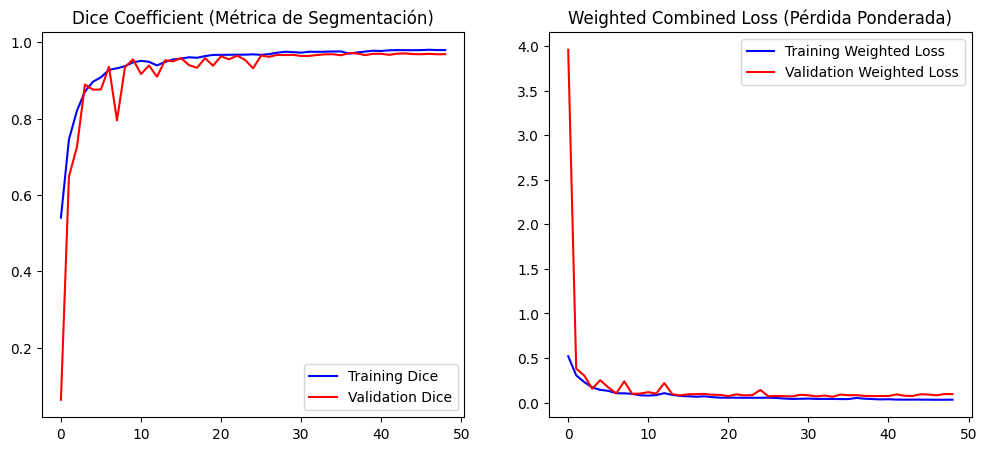

In [ ]:
plot_history(history)

Código para Visualización de Imágenes Completas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os

# --- CONFIGURACIÓN DE COLORES ---
# Paleta para 6 clases (Formato RGB)
COLORS = np.array([
    [0, 0, 0],       # 0: Fondo (Negro)
    [255, 0, 0],     # 1: MA (Rojo)
    [0, 255, 0],     # 2: HE (Verde)
    [0, 0, 255],     # 3: EX (Azul)
    [255, 255, 0],   # 4: SE (Amarillo)
    [0, 255, 255]    # 5: OD (Cyan)
], dtype=np.uint8)

CLASS_NAMES = ['Fondo', 'Micro (MA)', 'Hemo (HE)', 'Hard Ex (EX)', 'Soft Ex (SE)', 'Optic Disc (OD)']

# --- FUNCIÓN AUXILIAR 1: Cargar GT Completo ---
def load_full_gt_categorical(file_id, lesion_folders, img_shape):
    """
    Carga las 5 máscaras binarias y las combina en una sola imagen
    donde el valor del píxel es la clase (0-5).
    Maneja superposiciones dando prioridad.
    """
    h, w = img_shape[:2]
    # Inicializar imagen con Fondo (clase 0)
    gt_categorical = np.zeros((h, w), dtype=np.uint8)

    # Orden de prioridad para pintar (de menor a mayor prioridad).
    # Lo que se pinta al final queda encima.
    # Prioridad: OD > SE > EX > HE > MA
    lesion_order_priority = ['MA', 'HE', 'EX', 'SE', 'OD']

    for i, key in enumerate(lesion_order_priority, start=1):
        mask_filename = file_id + LESION_SUFFIXES[key]
        mask_path = os.path.join(lesion_folders[key], mask_filename)

        if os.path.exists(mask_path):
            # Cargar en gris, redimensionar al tamaño original y binarizar
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype(np.uint8)

            # Donde la máscara es 1, asignamos el índice de la clase 'i'
            # np.where reemplaza solo donde la condición es True
            gt_categorical = np.where(mask == 1, i, gt_categorical)

    return gt_categorical

In [ ]:
def debug_full_image_simple(model, img_id, test_img_dir, test_lesion_folders):
    print(f"--- DEBUGGING {img_id} ---")

    # 1. Cargar imagen
    path = os.path.join(test_img_dir, img_id + '.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. REDIMENSIONAR A LO BRUTO (Para probar si la red entiende la imagen global)
    # Usamos 512x512 o 1024x1024, algo que sea cuadrado como el entrenamiento
    debug_size = (1024, 1024)
    img_resized = cv2.resize(img, debug_size)

    # 3. Normalizar
    img_input = img_resized.astype(np.float32) / 255.0

    # 4. Predecir de golpe (Sin parches)
    # Nota: U-Net es "Fully Convolutional", puede aceptar tamaños distintos a 256
    # si la VRAM aguanta. 1024 suele aguantar.
    pred_prob = model.predict(np.expand_dims(img_input, axis=0))[0]
    pred_idx = np.argmax(pred_prob, axis=-1)

    # 5. Cargar GT y redimensionar igual
    gt_categorical = load_full_gt_categorical(img_id, test_lesion_folders, img.shape)
    gt_resized = cv2.resize(gt_categorical, debug_size, interpolation=cv2.INTER_NEAREST)

    # 6. Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_resized); ax[0].set_title("Input Resized")
    ax[1].imshow(COLORS[gt_resized]); ax[1].set_title("GT Resized")
    ax[2].imshow(COLORS[pred_idx]); ax[2].set_title("Prediction (Directa)")
    plt.show()


--- DEBUGGING IDRiD_55 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


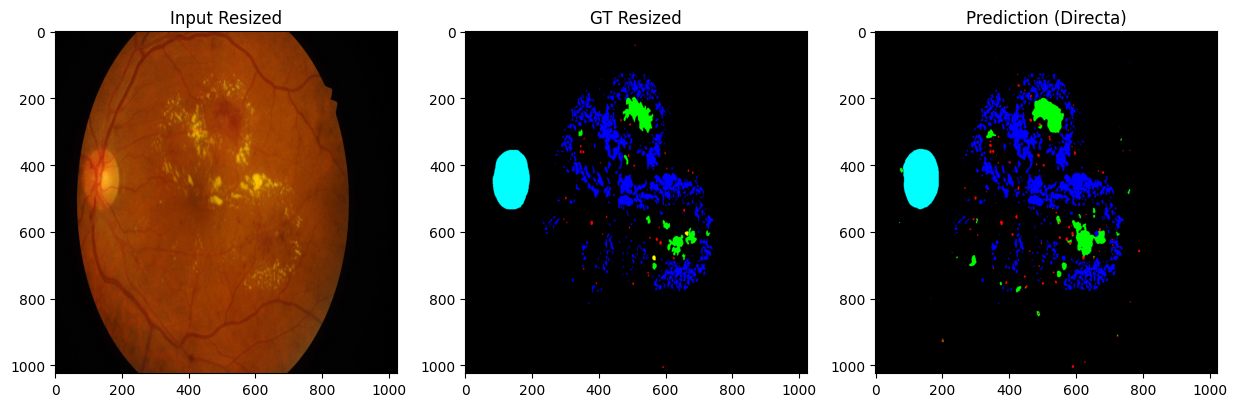

--- DEBUGGING IDRiD_56 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


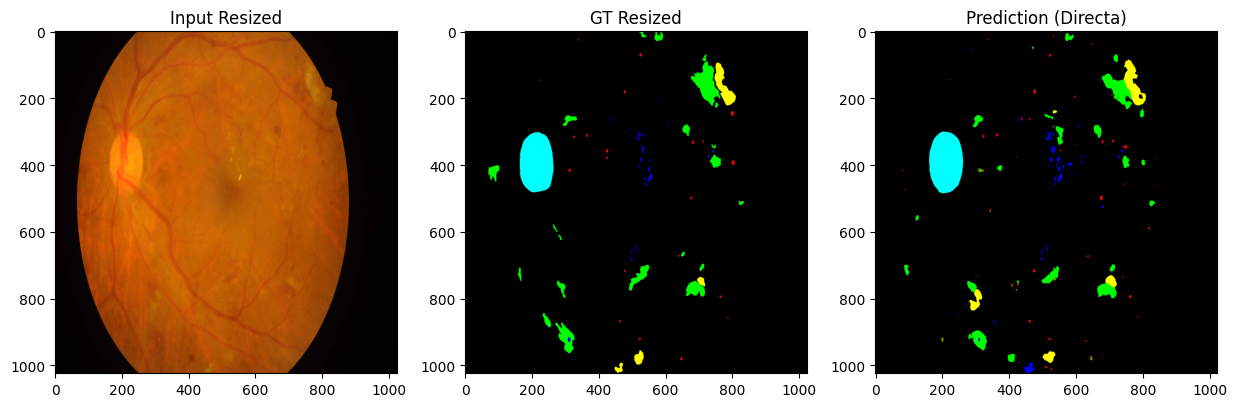

--- DEBUGGING IDRiD_81 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


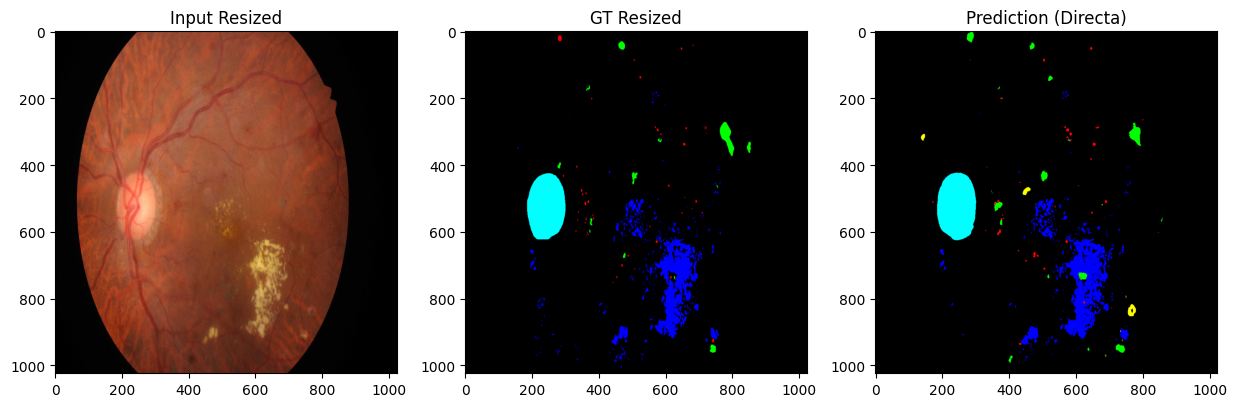

In [ ]:
debug_full_image_simple(model, 'IDRiD_55', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_56', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_81', TEST_IMG_DIR, TEST_LESION_FOLDERS)

Visualizando 5 ejemplos de segmentación completa...


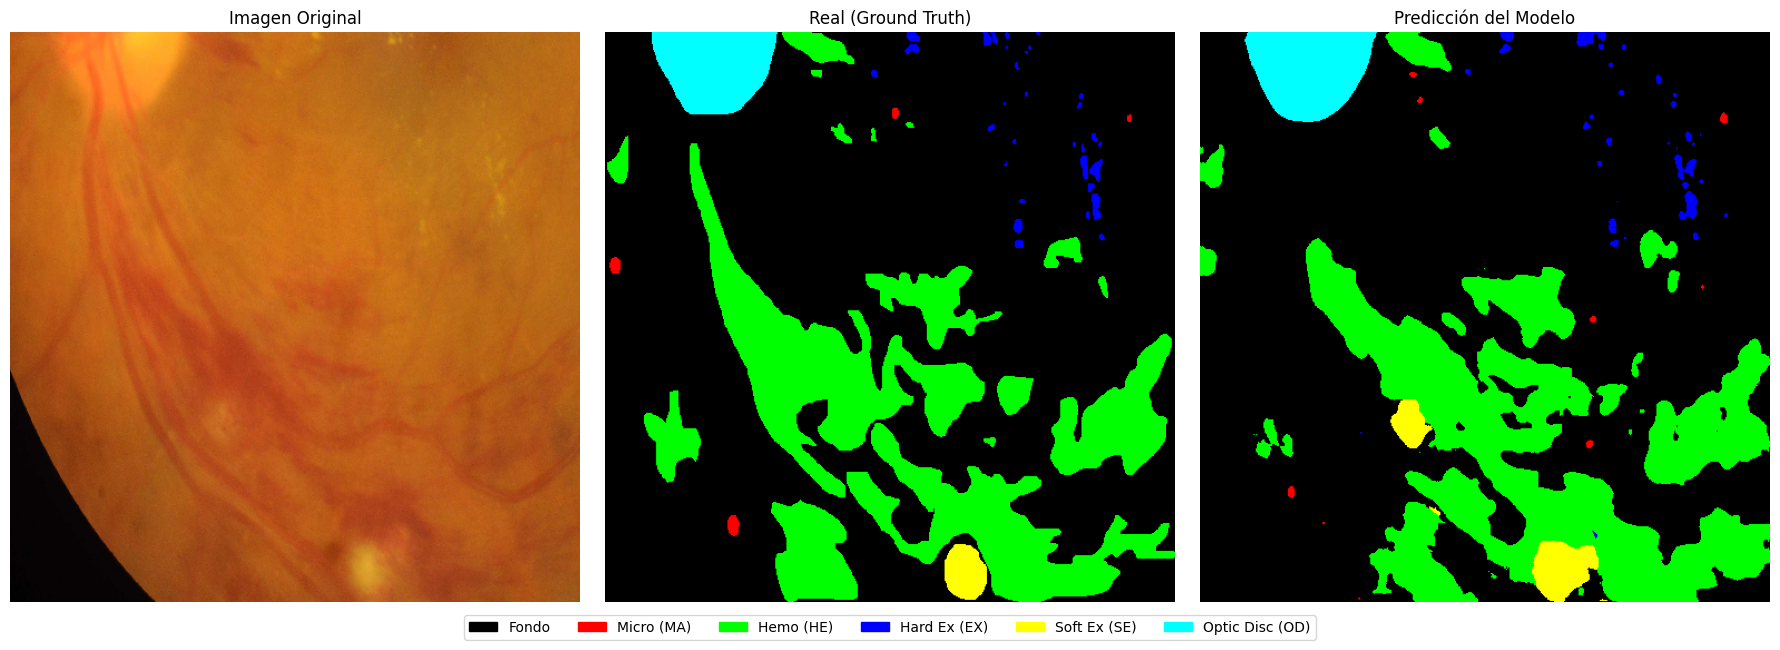

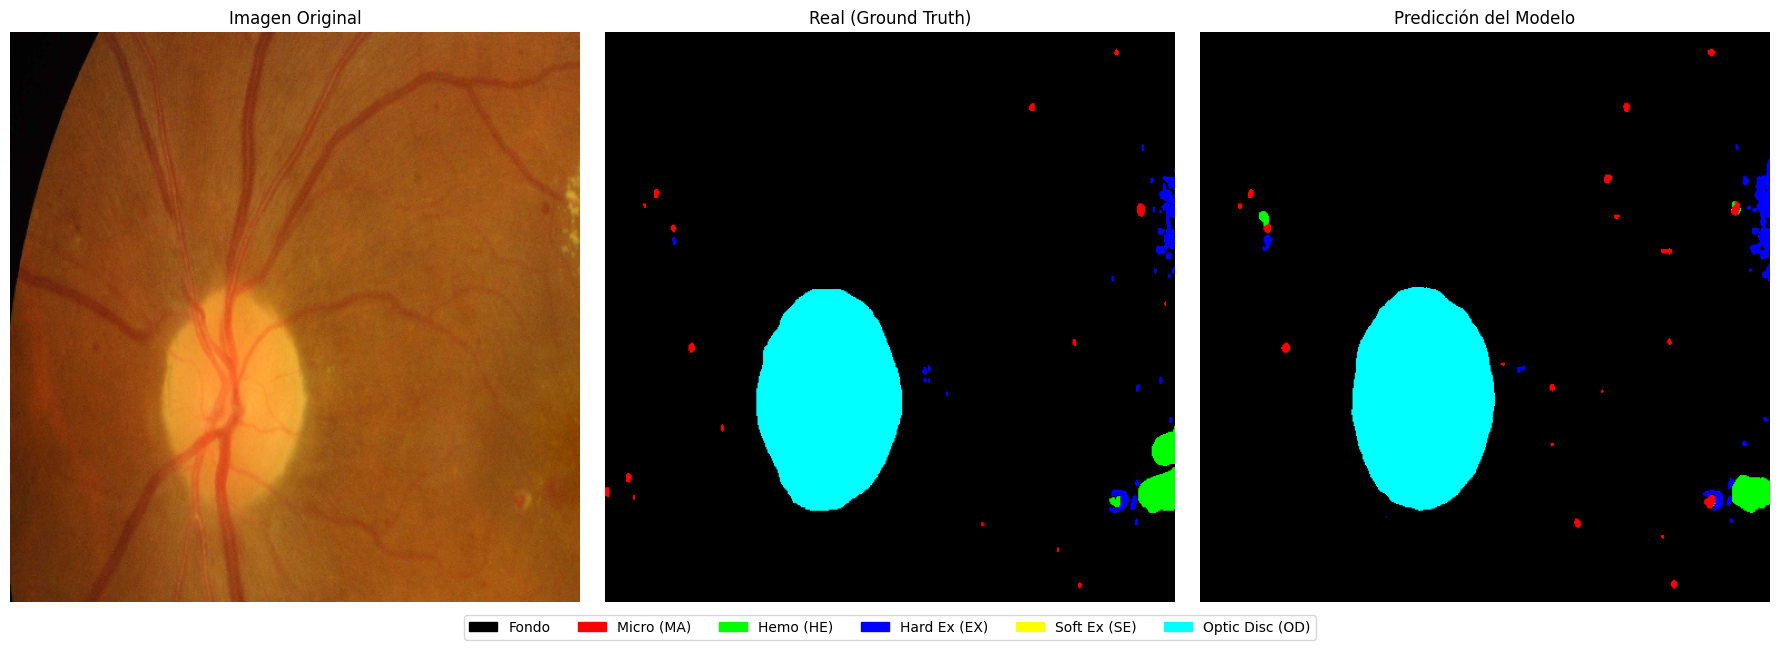

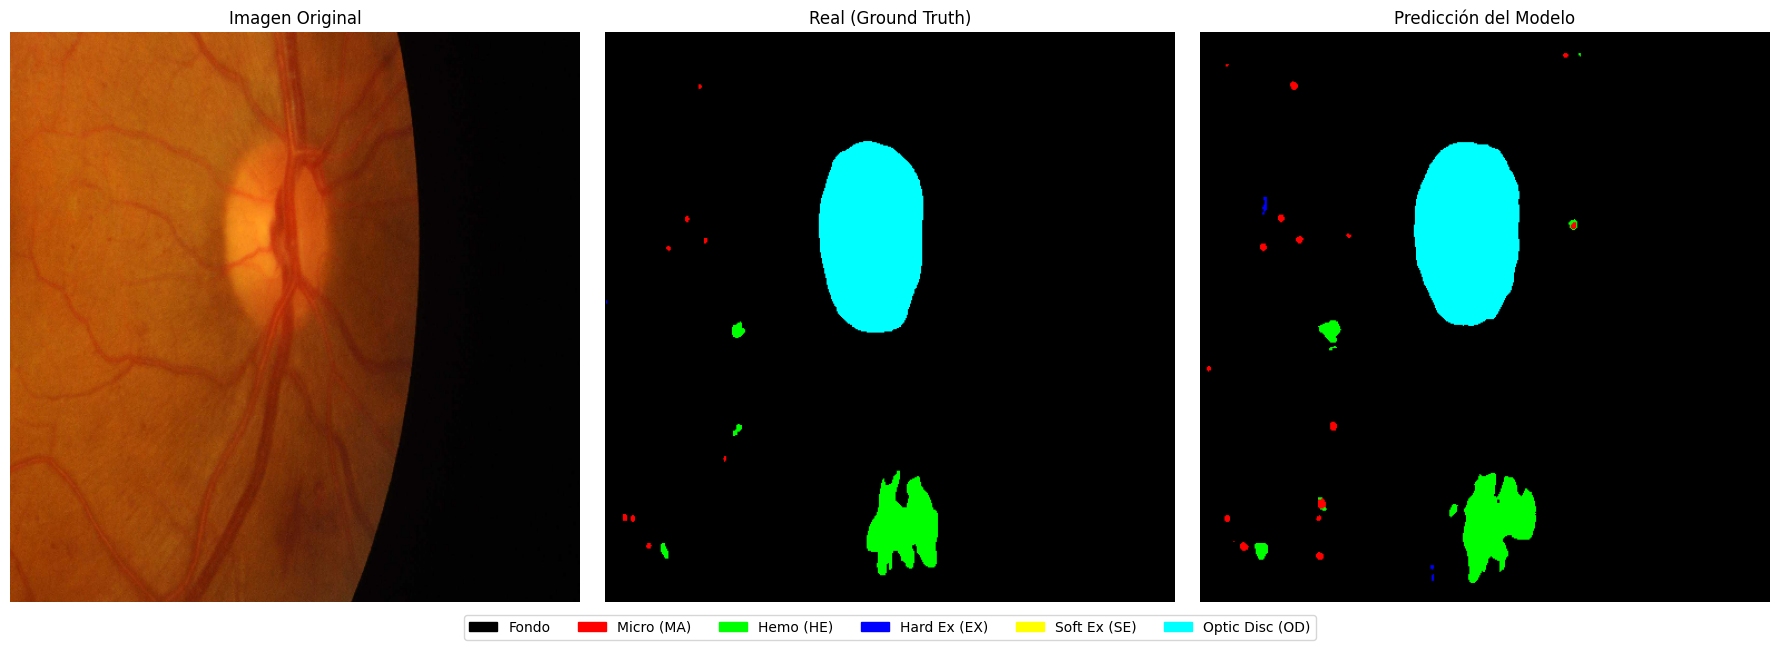

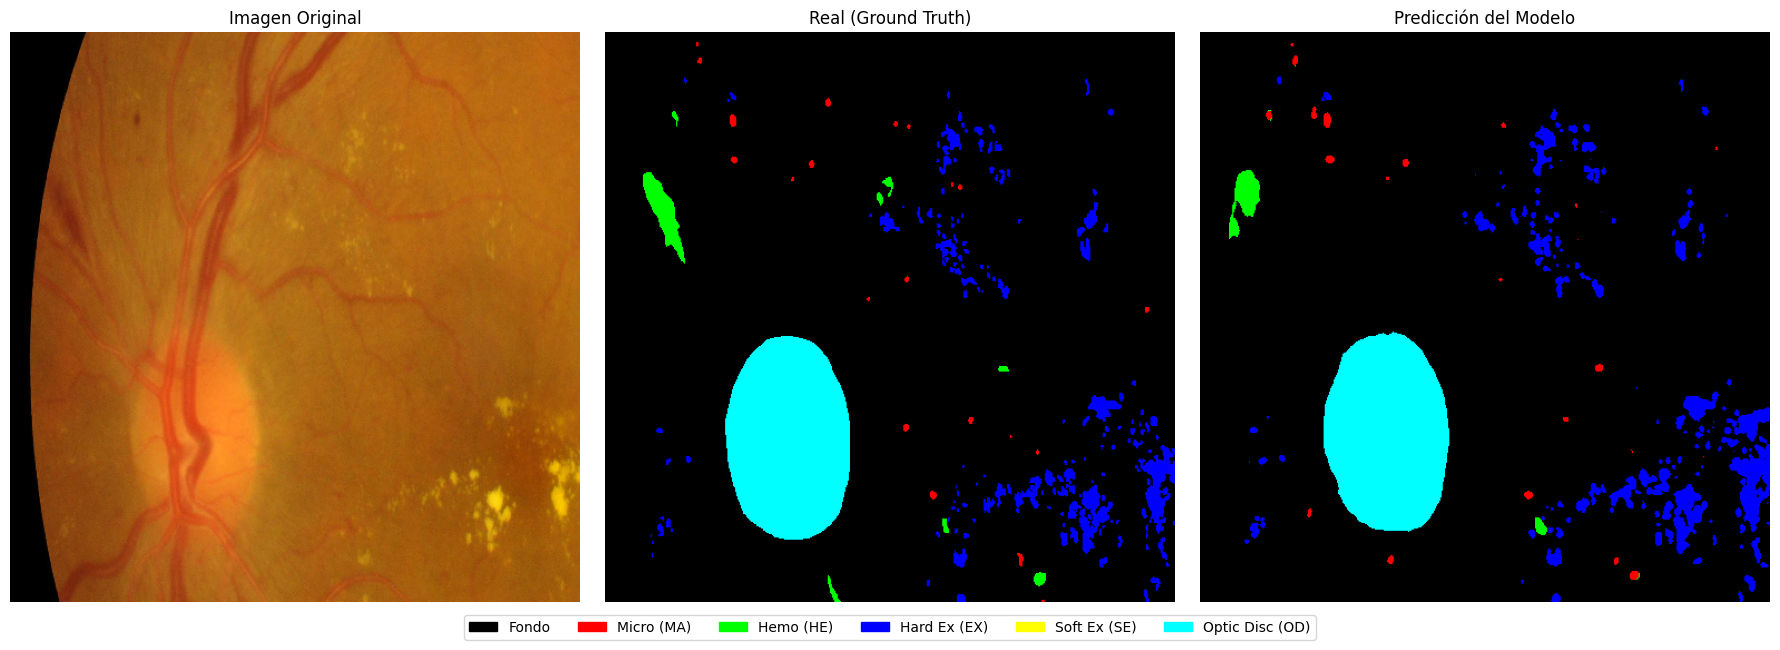

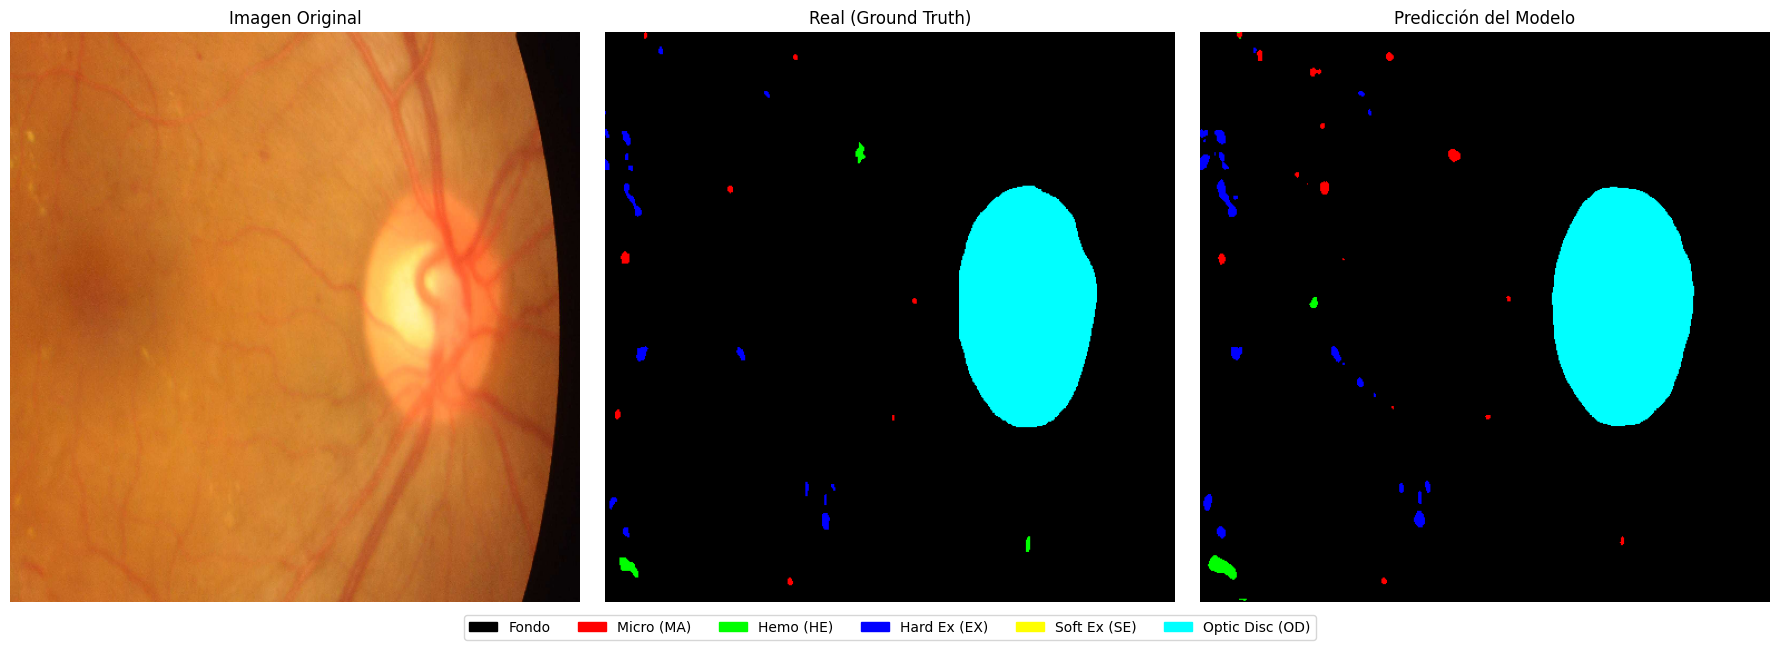

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_full_segmentation(model, generator, num_samples=1):
    """
    Visualiza la segmentación final completa (todas las clases en una imagen).
    Compara la imagen original, el mapa de segmentación real (Ground Truth)
    y el mapa de segmentación predicho por el modelo.
    """

    # Definir colores distintos para cada clase (Formato RGBA)
    # Usamos una paleta de alto contraste
    colors = np.array([
        [0, 0, 0, 255],       # 0: Fondo (Negro)
        [255, 0, 0, 255],     # 1: MA (Rojo brillante)
        [0, 255, 0, 255],     # 2: HE (Verde brillante)
        [0, 0, 255, 255],     # 3: EX (Azul brillante)
        [255, 255, 0, 255],   # 4: SE (Amarillo)
        [0, 255, 255, 255]    # 5: OD (Cyan)
    ], dtype=np.uint8)

    class_names = ['Fondo', 'Micro (MA)', 'Hemo (HE)', 'Hard Ex (EX)', 'Soft Ex (SE)', 'Optic Disc (OD)']

    print(f"Visualizando {num_samples} ejemplos de segmentación completa...")

    for i in range(num_samples):
        # Obtener un lote
        X_batch, y_true_batch = next(generator)
        img = X_batch[0]
        mask_true = y_true_batch[0]

        # Predicción
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

        # --- NÚCLEO DE LA VISUALIZACIÓN ---
        # Convertir de One-Hot (6 canales) a Mapa de Índices (1 canal con valores 0-5)
        seg_true_idx = np.argmax(mask_true, axis=-1)
        seg_pred_idx = np.argmax(pred_prob, axis=-1)

        # Convertir índices a imágenes RGB usando la paleta de colores
        seg_true_rgb = colors[seg_true_idx]
        seg_pred_rgb = colors[seg_pred_idx]

        # --- GRAFICAR ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. Imagen Original
        axes[0].imshow(img)
        axes[0].set_title("Imagen Original")
        axes[0].axis('off')

        # 2. Ground Truth (Coloreado)
        axes[1].imshow(seg_true_rgb)
        axes[1].set_title("Real (Ground Truth)")
        axes[1].axis('off')

        # 3. Predicción (Coloreado)
        axes[2].imshow(seg_pred_rgb)
        axes[2].set_title("Predicción del Modelo")
        axes[2].axis('off')

        # Crear leyenda personalizada
        patches = [mpatches.Patch(color=colors[c]/255.0, label=class_names[c]) for c in range(6)]
        fig.legend(handles=patches, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

        plt.tight_layout()
        plt.show()

# --- CÓMO EJECUTARLA ---
# Usa el generador de test completo para buscar ejemplos variados
visualize_full_segmentation(model, new_test_gen_full, num_samples=5)